In [64]:
import numpy as np
import scipy.linalg
import scipy.signal
import scipy.fftpack
import matplotlib.pyplot as plt

In [93]:
import numpy as np
def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u,rcond=None)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

In [115]:
n = 4096 # number of measurements
t = np.linspace(0.0, 1.0, num=n)

x = 5*np.cos(91*2*np.pi*t) + 1.9*np.cos(412*2*np.pi*t) + 3* np.cos(222* 2*np.pi*t)# original signal (to be reconstructed)

## Randomly sample signal
p = 128 
perm = np.round(np.random.rand(p) * n).astype(int)
y = x[perm]

xt = np.fft.fft(x) # Fourier transformed signal
PSD = xt * np.conj(xt) / n # Power spectral density

In [118]:
Psi = scipy.fftpack.dct(np.identity(n))
Theta = Psi[perm,:]

# l1 minimization (through linear programming)
s = cosamp2(Theta,y,10,epsilon=1.e-10,max_iter=20) 

xrec = scipy.fftpack.idct(s) # Reconstructed signal

xrect = np.fft.fft(xrec)
PSDrec = xrect * np.conj(xrect) / n


<ipython-input-12-6c4e73c1006d>:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b[omega], _, _, _ = np.linalg.lstsq(phiT, u)


C:\Users\Bram\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


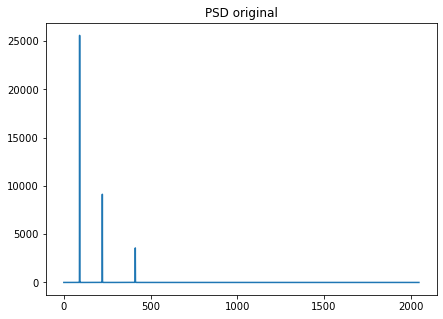

C:\Users\Bram\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


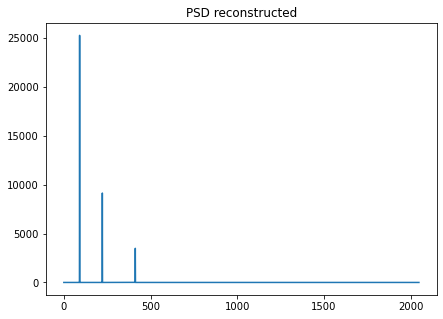

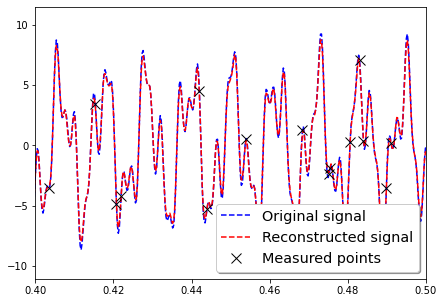

In [119]:
freq = np.arange(n)
L = int(np.floor(n/2))


figw, figh = 7.0, 5.0 # figure width and height
plt.figure(figsize=(figw, figh))
plt.plot(freq[:L],PSD[:L] )
plt.title('PSD original')
plt.show()


figw, figh = 7.0, 5.0 # figure width and height
plt.figure(figsize=(figw, figh))
plt.plot(freq[:L],PSDrec[:L] )
plt.title('PSD reconstructed')
plt.show()



# Visualize the compressed-sensing reconstruction signal

figw, figh = 7.0, 5.0 # figure width and height
plt.figure(figsize=(figw, figh))
plt.plot(t, x,    'b', linestyle= '--',label='Original signal')
plt.plot(t, xrec, 'r', linestyle= '--',label='Reconstructed signal')
plt.plot(t[perm],y, linestyle='none',color='k', marker = 'x',markersize=10, label= 'Measured points')
plt.xlim(0.4, 0.5)
legend = plt.legend(shadow=True, fontsize='x-large')


plt.show()